# Przemysław Kaleta
Data: https://data.stanford.edu/hcmst2017

In [89]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb

from collections import defaultdict

In [2]:
data = pd.read_stata("hcmts.dta")

Explanations of variable names taken from:

https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf

* Yes/no questions:
    * **Q5** Is [Partner name] the same sex as you? 
    * **Q25_2** Did you and [Partner name] attend the same high school?
    * **Q10** Highest level of schooling of partner
    * **hcm2017q24_met_online** Met online
    
* Quantitative questions:
    * **w6_q9** partner age in 2017
    * **w6_q24_length** length of q24 how met answer in characters

In [3]:
binary_variables = ["Q5", "Q25_2", "Q26_2",  "hcm2017q24_met_online"]
continuous_variables = ["w6_q9", "w6_q24_length"]
predicted_variables = ["S1"]
variables = binary_variables + continuous_variables + predicted_variables
mydata = data.loc[data.S1.notna(), variables]

## Model

In [4]:


# Dictionary with keys as columns of categorical variables 
# and values as functions which for a given code tell us what category it is
name_from_code = defaultdict(lambda: lambda x: x)

# usage: name_from_code["column_name"](code)
# If column name is not in binary variables name_from_code["column_name"] is an identity function.

for column_name in binary_variables + predicted_variables:
    
    column = mydata[column_name].values
    
    def _name_from_code(x, col=column):
        return col.from_codes([x], col.categories)[0]
    
    name_from_code[column_name] = _name_from_code
    
    mydata[column_name] = column.codes
    


In [5]:
X, y = mydata.drop("S1", axis=1), mydata["S1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.35,
                max_depth = 5, alpha = 0, n_estimators = 100)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

def test_classifier(y_true, y_pred):
    n = len(y_true)
    print(f"Positive/negative percentages in population: {sum(y_true) / n} / {sum(y_true == 0) / n}")
    print(f"Accuracy {sum(y_true == y_pred) / n}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    
test_classifier(y_test, y_pred)

colnames = X_train.columns
names_explained_list = ["same_sex", "high_school", "university", "met_online", "partner_age", "w6_q24_length"]
names_explained = {colname: colname_explained for colname, colname_explained in zip(colnames, names_explained_list)}

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.8076923076923077
F1 score: 0.7283702213279677


In [124]:
# Filling unknown values with means
means = X_train.apply(lambda x: x.mean(), axis=0)
X_train = X_train.fillna(dict(means))
X_test = X_test.fillna(dict(means))
mydata = mydata.fillna(dict(means))

In [73]:
logreg_model = LogisticRegression(solver="liblinear")
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
test_classifier(y_test, y_pred)

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.7749287749287749
F1 score: 0.6594827586206897


# Feature Importance
Zbadamy jak cechy są ważne w obydwu modelach (xgboost i model logistyczny). Modele te mają różną strukture, dlatego żeby je porównac obliczymy scory niezależne od konkretnego modelu. Może to być na przykład zwykła skuteczność na zbiorze testowym, lub też F1.

In [113]:
def feature_importance(X: pd.DataFrame, y, model, score_measure=None):
    """For a given model and data returns a dictionary with importance of each feature
    score: a measure of goodness of fit, e.g accuracy_score or f1_score"""
    score_measure = score_measure or accuracy_score
    
    scores = dict()
    base_score = score_measure(model.predict(X), y)
    for column in X.columns:
        random_shuffle = np.random.permutation(X[column].values)
        X_new = X.copy()
        X_new[column] = random_shuffle
        # Base score should be higher because the data is unchanged
        scores[column] = base_score / score_measure(model.predict(X_new), y)
    return scores

xgb_feature_importance = feature_importance(X_test, y_test, xgb_model)
xgb_feature_importance

{'Q5': 1.0,
 'Q25_2': 1.1540084388185654,
 'Q26_2': 1.026266416510319,
 'hcm2017q24_met_online': 1.0148423005565863,
 'w6_q9': 1.0874751491053678,
 'w6_q24_length': 1.007366482504604}

In [110]:
logreg_feature_importance = feature_importance(X_test, y_test, logreg_model)
logreg_feature_importance

{'Q5': 0.9853747714808043,
 'Q25_2': 1.2334096109839818,
 'Q26_2': 1.0037243947858474,
 'hcm2017q24_met_online': 0.9944649446494466,
 'w6_q9': 1.1,
 'w6_q24_length': 1.0037243947858474}

In [111]:
def plot_importance(feature_imporances):
        plt.bar([names_explained[name] for name in feature_imporances.keys()], feature_imporances.values())
        plt.xticks(rotation=50)
        plt.show()

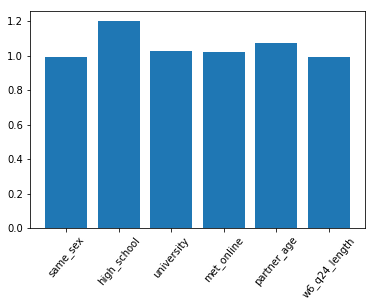

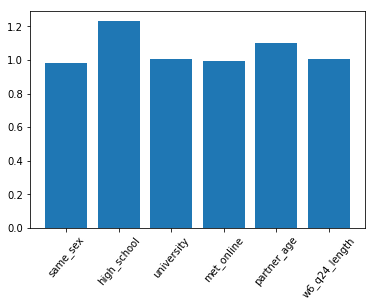

In [112]:
plot_importance(xgb_feature_importance)
plot_importance(logreg_feature_importance)

Nie widzimy praktycznie żadnej różnicy w ocenie ważności danej cechy. Wyraźnie ważniejsza jest zmienna mówiąca o chodzeniu do tej samej szkoły średniej, co jest trochę niezrozumiałe, bo większość zmiennych była nieznana dla tej cechy. Istotna w obu modelach jest tez zmienna mówiąca o wieku partnera. Trochę dziwne jest dla mnie że sa one równie istotne w obu modelach , bo zgodnie z obserwacjami z poprzednich prac zależność od zmiennej wieku była nieliniowa: najpierw rosła, ale od pewnego wieku malała.

# Partial Dependency Plots

In [121]:
def partial_dependency_plot(data, model, colname, k=10):
    """Plots average Ceteris Paribus profile for sample population (k observations) from data"""
    
    def get_proba(person, colname, colvalue):
        new_person = pd.DataFrame([person.values], columns=data.columns[:-1])
        if colname not in X_train.columns:
            raise Exception("Wrong column name")
        new_person[colname] = colvalue
        return model.predict_proba(new_person)[0][0]
    

    min_value = np.quantile(data[colname].dropna(), 0.01, interpolation="higher")
    max_value = np.quantile(data[colname].dropna(), 0.99, interpolation="lower")
    values = np.linspace(min_value, max_value, 100)
    
    probas_list = [[get_proba(person, colname, value) for value in values] 
                   for _, person in data.drop("S1", axis=1).sample(k).iterrows()]
    mean_probas = [np.mean(values) for values in zip(*probas_list)]
    
    plt.plot(values, mean_probas)
    plt.title("Partial dependency plot")
    plt.xlabel(colname)
    plt.ylabel("Marriage probability")
    plt.show()

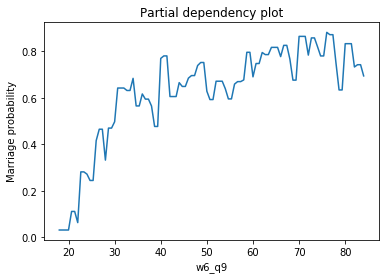

In [122]:
partial_dependency_plot(mydata, xgb_model, "w6_q9")

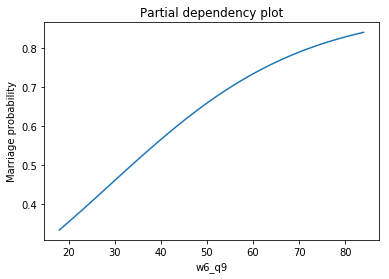

In [125]:
partial_dependency_plot(mydata, logreg_model, "w6_q9")

W obu modelach zależność jest ogólnie rosnąca, natomiast dużo widoczniej widać to dla modelu logistycznego. To, że poszczególne krzywe Ceteris Paribus w modelu są monotoniczne nie jest niczym dziwnym, i wynika wprost z definicji modelu, który estymuje prawdopodobieństwo bezpośrednio na podstawie kombinacji liniowej współczynników. Nie widać więc tych zaburzeń, co w modelu xgboost, który ma większa wariancję i być może za bardzo dopasowuje się do danych, które zresztą nie są najlepsze i zawierają duzo wartości brakujących. Widzimy tu zaletę prostszych modeli, które dużo łatwiej interpretować.